# Introduction

Company "X" is an e-commerce company that sells handmade clothing.

In this notebook, we are going analyze a list of transactions from the company's database and build a model that detects fraudulent transactions.

First, we are going to explore and process our data. Then, we are going to build and evaluate several classification models for our problem.

# 1 - Importing libraries

First, let's install and import some libraries for data exploration and processing.

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np
from datetime import datetime

# Data preprocessing and modeling libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

Now, let's load our transactions data.

# 2 - Loading data

## 2.1 - Transactions data

This dataset contains a list of unique transactions for an E-commerce site. Each transaction has some information such as :

**Features :**
* **user_id**: unique ID of the user
* **signup_time**: The exact time the user signed up to the website
* **purchase_time**: The exact time the transaction happened
* **purchase_value**: amount of transaction
* **device_id**
* **source**
* **browse**r: The browser used for the transaction
* **sex**: gender of the user
* **age**: age of the user
* **ip_address**: IP address of the user

**Target variable (class)**

* **0** if non fraudulent transaction
* **1** if the transaction is fraudulent

In [2]:
# Load transactions data
data = pd.read_csv("Fraud_Data.csv")

# Data preview
display(data.head())

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


## 2.2 - IP address - Country mapping data

This dataset allows to derive the country of the user based on his IP address. If an IP address is within a specif interval (defined by a lower bound and an upper bound), it can be mapped to a specific country. 

In [3]:
# Loading mapping data
ip_country = pd.read_csv("IpAddress_to_Country.csv")

# Data preview
display(ip_country.head())

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


# 3 - Exploratory Data Analysis

## 3.1 - General description

Looking at our dataset's shape, we notice that we have a significant amount of observations (150K) and few explanatory variables (10).

In [4]:
# Shape obh the dataset
print("Number of rows : {}".format(data.shape[0]))
print("Number of columns : {}".format(data.shape[1]))

Number of rows : 151112
Number of columns : 11


Also, looking at some quick statistics on our data, we notice that:

* We do not have any missing values accross the dataset
* There are no incoherent values
* Our data is largely skewed as we have only 9.36% of fraudulent transactions

In [5]:
data.describe(include="all")

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
count,151112.000000,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,1.511120e+05,151112.000000
unique,NaN,151112,150679,NaN,137956,3,5,2,NaN,NaN,NaN
top,NaN,2015-01-19 15:17:35,2015-06-08 09:42:04,NaN,ITUMJCKWEYNDD,SEO,Chrome,M,NaN,NaN,NaN
freq,NaN,1,3,NaN,20,60615,61432,88293,NaN,NaN,NaN
mean,200171.040970,NaN,NaN,36.935372,NaN,NaN,NaN,NaN,33.140704,2.152145e+09,0.093646
std,115369.285024,NaN,NaN,18.322762,NaN,NaN,NaN,NaN,8.617733,1.248497e+09,0.291336
min,2.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000
25%,100642.500000,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085934e+09,0.000000
50%,199958.000000,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,33.000000,2.154770e+09,0.000000
75%,300054.000000,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,39.000000,3.243258e+09,0.000000


## 3.2 - Time columns

Before contiuing our EDA, we must handle time features (purchase time & signup time) to extract some useful information.

### 3.2.1 - Conversion to datetime

In [6]:
# General data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


"signup_time" and "purchase_time" are formatted as object type. They have to be converted to datetime in order to be exploited and integrated in an evental model. The pandas method *to_datetime()* can be used to achieve that.

In [7]:
# Converting time columns from object to datetime format
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])

# Checking if the conversion was successful
data[['signup_time', 'purchase_time']].dtypes

signup_time      datetime64[ns]
purchase_time    datetime64[ns]
dtype: object

### 3.2.2 - Time features extraction and exploration

Now that we have successfully converted our data, we can derive some additional information such as the month and date. Our data is only for 2015 transactions so we won't be using the year information.

In [8]:
# Deriving purchase month and day
data['purchase_month'] = data['purchase_time'].dt.month
data['purchase_day'] = data['purchase_time'].dt.day

# Deriving sign-up month and day
data['signup_month'] = data['signup_time'].dt.month
data['signup_day'] = data['signup_time'].dt.day




Since we are facing a classification problem, we can visualize the potential relationship between our new features and the fraud status. From the plots below, we can see a clearly that **most fraudulent transactions occure in January**, and usually **within the first half of the month**.

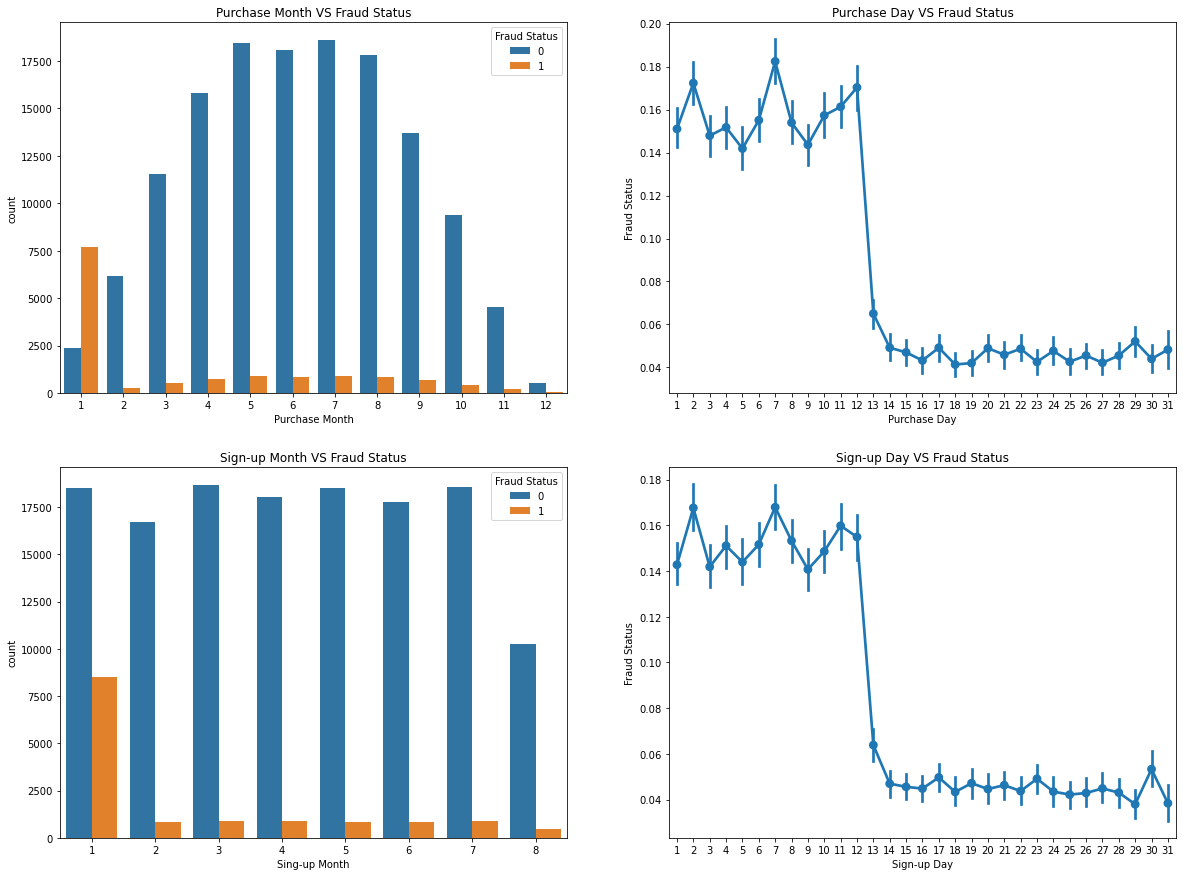

In [9]:
# Plotting time features VS fraud status
fig, ax = plt.subplots(2,2, figsize=(20,15))

# Purchase Month VS Fraud Status
plt.subplot(2, 2, 1)
ax[0,0] = sns.countplot(x='purchase_month', hue='class', data=data)
ax[0,0].set_title('Purchase Month VS Fraud Status')
ax[0,0].set_xlabel('Purchase Month')
ax[0,0].legend(title='Fraud Status')

# Purchase Day VS Fraud Status
plt.subplot(2, 2, 2)
ax[0,1] = sns.pointplot(x='purchase_day', y='class', data=data)
ax[0,1].set_title('Purchase Day VS Fraud Status')
ax[0,1].set_xlabel('Purchase Day')
ax[0,1].set_ylabel('Fraud Status')

# Sign-up Month VS Fraud Status
plt.subplot(2, 2, 3)
ax[1,0] = sns.countplot(x='signup_month', hue='class', data=data)
ax[1,0].set_title('Sign-up Month VS Fraud Status')
ax[1,0].set_xlabel('Sing-up Month')
ax[1,0].legend(title='Fraud Status')

# Sign-up Day VS Fraud status
plt.subplot(2, 2, 4)
ax[1,1] = sns.pointplot(x='signup_day', y='class', data=data)
ax[1,1].set_title('Sign-up Day VS Fraud Status')
ax[1,1].set_xlabel('Sign-up Day')
ax[1,1].set_ylabel('Fraud Status')

# Display figure
plt.show()

Intuitively, one could say that **fraudulent transactions happen with new users rather than old ones**. We could easily check that by computing the time **difference between sign-up an purchase time**.

In [10]:
# Computing time delta
data['time_delta'] = (data['purchase_time'] - data['signup_time']).astype('timedelta64[s]')

The below plot confirms our intuition: most of fraudulent transactions come from new users

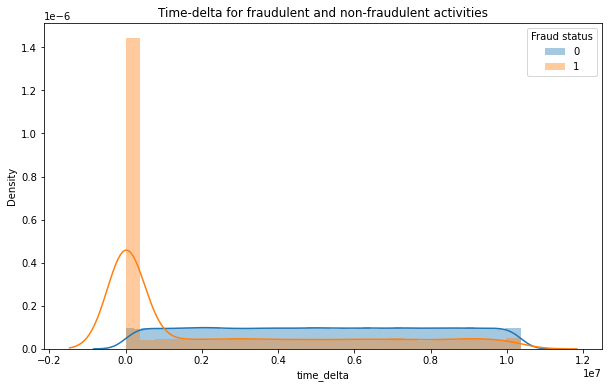

In [11]:
# plotting time-delta data
plt.figure(figsize=(10,6))

for c in set(data['class']):
    sns.distplot(data.loc[data['class']==c, 'time_delta'], label=c)
    
plt.legend(title="Fraud status")
plt.title("Time-delta for fraudulent and non-fraudulent activities")

# Display figure
plt.show()

## 3.3 - Purchase value

Let's look at the distribution of purchase values for each fraud status.

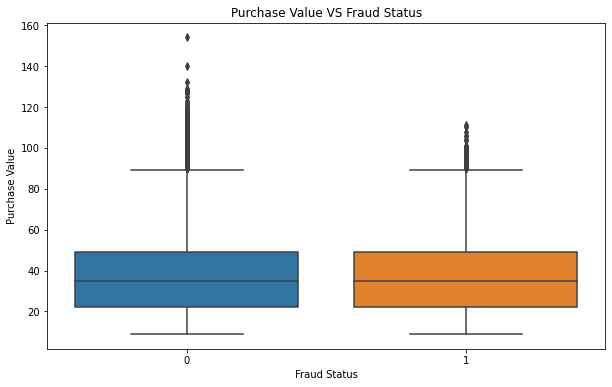

In [12]:
# Purchase value VS fraud status
plt.figure(figsize=(10,6))
sns.boxplot(x='class' , y='purchase_value', data=data)

plt.xlabel('Fraud Status')
plt.ylabel('Purchase Value')
plt.title('Purchase Value VS Fraud Status')

plt.show()

Looking at the distribution of purchase value data, **we cannot conclude on a relationship** with our target data since **both fraudulent and non-fraudulent transactions fall into the same range**. However let's keep this feature for our model.

## 3.4 - Device ID

In [13]:
# Count of unique device Ids
data['device_id'].nunique()

137956

The device ID has too much modalities accross the dataset and can't be used as it is, we will not considered it for the classification.

## 3.5 - Source

In [14]:
# Value counts for Source feature
data['source'].value_counts()

SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64

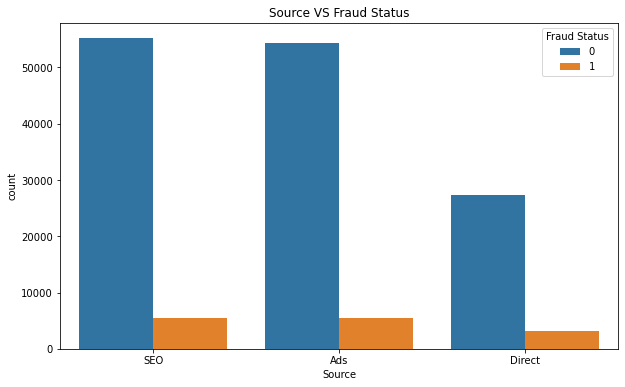

In [15]:
# Source VS Fraud Status
plt.figure(figsize=(10,6))
sns.countplot(x='source', hue='class', data=data)
plt.title('Source VS Fraud Status')
plt.xlabel('Source')
plt.legend(title='Fraud Status')
plt.show()

**We cannot conclude on a clear relationship between the Fraud Status and the Source feature**.

## 3.6 - Browser

In [16]:
# Value counts for Browser feature
data['browser'].value_counts()

Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64

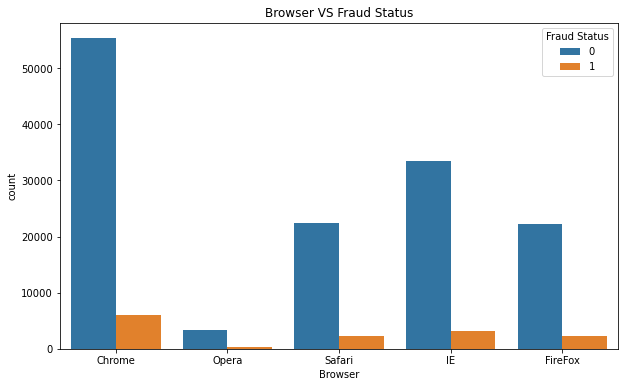

In [17]:
# Browser VS Fraud Status
plt.figure(figsize=(10,6))
sns.countplot(x="browser", hue="class", data=data)
plt.title('Browser VS Fraud Status')
plt.xlabel('Browser')
plt.legend(title='Fraud Status')
plt.show()

Most of fraudulent transactions were performed using Google Chrome followed by Internet Explorer.

## 3.7 - Age

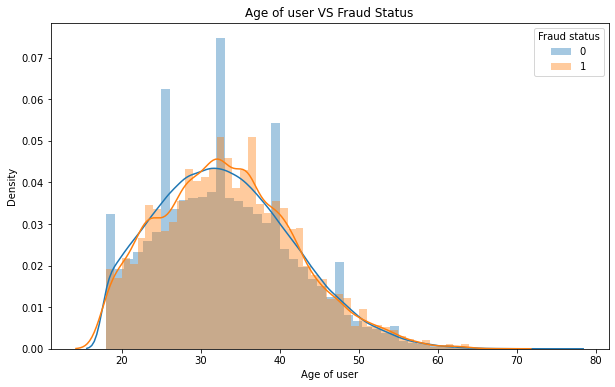

In [18]:
# Age VS Fraud Status
plt.figure(figsize=(10,6))

for c in set(data['class']):
    sns.distplot(data.loc[data['class']==c, 'age'], label=c)
    
plt.title('Age of user VS Fraud Status')
plt.xlabel('Age of user')
plt.legend(title='Fraud status')
plt.show()

The distributions of age variables for both fraudulent and non-fraudulent activities are the almost the same. Once again, one cannot conclude on the fraud status of a transaction based on the age of the user.

## 3.8 - IP address

The IP address as it is in our dataset can't be integrated into a ML model. However, as previously mentionned, we can derive the country from an IP address using the "ip_country" dataset.

In [19]:
# Function that returns the country from an IP address
def transform_ip(arg):
    try:
        return ip_country.country[(ip_country.lower_bound_ip_address < arg) & (ip_country.upper_bound_ip_address > arg)].iloc[0]
    except IndexError:
        return "Unknown country"  

# Applying our function to the ip_address column
data["country"] = data["ip_address"].apply(transform_ip)

In [20]:
# Data preview
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,purchase_month,purchase_day,signup_month,signup_day,time_delta,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,4,18,2,24,4506682.0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,6,8,6,7,17944.0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,1,1,1,1,1.0,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,5,4,4,28,492085.0,Unknown country
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,9,9,7,21,4361461.0,United States


In [31]:
# Numbe of unique countries
data['country'].nunique()

182

# 4 - Filtering out unnecessary data

## 4.1 - Dropping features

After our EDA, we conclude that we can drop the following columns:

* user_id: unique id, does not contain useful information
* signup_time, signup_month, signup_day: redundant with purchase_day, purchase_month and time_delta
* device_id: Does not contain useful information
* ip_address: Not useful, we derived the country from it

In [22]:
# Dropping columns
to_drop = ['user_id', 'signup_time', 'signup_month', 'signup_day', 'purchase_time', 'device_id', 'ip_address']
data_processed = data.drop(columns=to_drop, axis=1)
data_processed.head()

,purchase_value,source,browser,sex,age,class,purchase_month,purchase_day,time_delta,country
0,34,SEO,Chrome,M,39,0,4,18,4506682.0,Japan
1,16,Ads,Chrome,F,53,0,6,8,17944.0,United States
2,15,SEO,Opera,M,53,1,1,1,1.0,United States
3,44,SEO,Safari,M,41,0,5,4,492085.0,Unknown country
4,39,Ads,Safari,M,45,0,9,9,4361461.0,United States


## 4.2 - Additional cleaning

Some countries are very rare. In the following, we will not consider the countries that are represented more that 50 times.

In [23]:
# Defining a count of countries Pandas Series
country_counts = data_processed['country'].value_counts()

# Defining the list of countries to keep
to_keep = country_counts[country_counts > 50].index.values

# Filtering out data
data_processed = data_processed.loc[data_processed['country'].isin(to_keep), :].reset_index(drop=True)
data_processed.head()

,purchase_value,source,browser,sex,age,class,purchase_month,purchase_day,time_delta,country
0,34,SEO,Chrome,M,39,0,4,18,4506682.0,Japan
1,16,Ads,Chrome,F,53,0,6,8,17944.0,United States
2,15,SEO,Opera,M,53,1,1,1,1.0,United States
3,44,SEO,Safari,M,41,0,5,4,492085.0,Unknown country
4,39,Ads,Safari,M,45,0,9,9,4361461.0,United States


In [24]:
print("Number of rows in the processed dataset : {} rows".format(data_processed.shape[0]))
print("Number of columns in the processed dataset : {} columns".format(data_processed.shape[1]))

Number of rows in the processed dataset : 149933 rows
Number of columns in the processed dataset : 10 columns


# 5 - Machine Learning

In this section, we will process our data and build predictive machine learning models to detect fraudulent transactions.

## 5.1 - Setting train and test data

In [25]:
# Printing the list of potential features
print(data_processed.columns.values)

['purchase_value' 'source' 'browser' 'sex' 'age' 'class' 'purchase_month'
 'purchase_day' 'time_delta' 'country']


Let's define some useful variables that will help us construct our pipeline:

In [26]:
# Defining the list of selected features
features_list = ['time_delta', 'purchase_value', 'age',
                 'source', 'browser', 'sex', 'country',
                 'purchase_month', 'purchase_day']

# Indentifying the indexes of numerical and categorical features
numeric_indices = [0, 1, 2]
categorical_indices = [3, 4, 5, 6, 7, 8]

# Defining the target variable
target_variable = 'class'

Now, let's split our explanatory variables and target variable into two separate dataframes.

In [27]:
# Features dataframe
X = data_processed.loc[:, features_list]

# Labels dataframe
y = data_processed.loc[:, target_variable]

print('Explanatory variables: ', X.columns.values)

Explanatory variables:  ['time_delta' 'purchase_value' 'age' 'source' 'browser' 'sex' 'country'
 'purchase_month' 'purchase_day']


We are now ready to split our data into training and testing data. The method train_test_split() is used to do so. As our data is largely skewed, we used the "stratify" parameter to reproduce the same distribution of the target labels into our training and testing data.

In [28]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, stratify=y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [29]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(y_train[0:5])
print(y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[7124079.0 22 41 'SEO' 'Safari' 'M' 'United States' 6 25]
 [6970977.0 41 33 'SEO' 'FireFox' 'F' 'United Kingdom' 3 27]
 [1357239.0 28 45 'SEO' 'Chrome' 'F' 'United States' 2 23]
 [5402697.0 32 36 'Direct' 'Safari' 'F' 'Unknown country' 7 28]
 [8387086.0 39 29 'SEO' 'FireFox' 'M' 'Denmark' 4 13]]
[[5844173.0 15 39 'Ads' 'Safari' 'F' 'Denmark' 7 12]
 [3844857.0 50 35 'Ads' 'Chrome' 'M' 'Ireland' 2 22]]

[0 0 0 1 0]
[0 0]


## 5.2 - Features processing

The last step before training our models is to transform and standerdize our data :

* Numerical columns: Strandard scaling
* Categorical columns: One Hot encoding 

The Pipeline() and ColumnTransformer() are used to define a series of transformations to apply to specific columns.

In [30]:
# Creating a preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())
                                     ]
                              )
    
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(drop='first'))
                                         ]
                                  )

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

In [32]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

# Fitting and transforming training data
X_train = preprocessor.fit_transform(X_train)

# Transforming ONLY our testing data to prevent data leakage
X_test = preprocessor.transform(X_test)

print("...Done")
print(X_train[0:5, :])

Encoding categorical features and standardizing numerical features...
...Done
  (0, 0)	0.700838193204952
  (0, 1)	-0.8131614140682454
  (0, 2)	0.9124683309381226
  (0, 4)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 82)	1.0
  (0, 91)	1.0
  (0, 121)	1.0
  (1, 0)	0.6518837660002775
  (1, 1)	0.22402011232326413
  (1, 2)	-0.015572967191998093
  (1, 4)	1.0
  (1, 5)	1.0
  (1, 81)	1.0
  (1, 88)	1.0
  (1, 123)	1.0
  (2, 0)	-1.1431112586703
  (2, 1)	-0.48563040573408445
  (2, 2)	1.376488980003183
  (2, 4)	1.0
  (2, 82)	1.0
  (2, 87)	1.0
  (2, 119)	1.0
  (3, 0)	0.150425593693274
  (3, 1)	-0.2672764001779772
  (3, 2)	0.33244251960679716
  (3, 3)	1.0
  (3, 8)	1.0
  (3, 83)	1.0
  (3, 92)	1.0
  (3, 124)	1.0
  (4, 0)	1.1046851987339084
  (4, 1)	0.1148431095452105
  (4, 2)	-0.47959361625705843
  (4, 4)	1.0
  (4, 5)	1.0
  (4, 9)	1.0
  (4, 25)	1.0
  (4, 89)	1.0
  (4, 109)	1.0


## 5.3 - Evaluation metrics

#### Interpreting the scores

* The **precision** represents the "purity" of the predictions "1". In other words, it's the ratio of examples being predicted as 1s that are indeed true 1s: $P = \frac{TP}{TP + FP}$ 
* The **recall** represents the ability to detect the true "1". It's the ratio of examples that are true 1s and have been predicted as 1s: $R = \frac{TP}{TP + FN}$ 
* From the formulae above, one can see the the precision is maximal when there are no false positives, and the recall is maximal when there are no false negatives
* The **F1-score** is a harmonic average between Precision and Recall. It allows to account for both false positivies and false negatives, which very useful when dealing with class imbalance: $F1 = 2.\frac{P . R}{P + R}$ 

#### What does that mean in the context of fraud detection ?

* False positives represent transactions that are reported as frauds but in fact aren't
* False negatives represent frauds that are not detected (this is the kind of error that we want to avoid)
* In this case, **we would like to detect as much frauds as possible while having a number of false positives that is as close as possible to 0 (because we want to avoid fake alerts that would be time-consuming for the company)**

## 5.4 - Logistic Regression

In this part, we will perform a Logistic Regression on our data. We will use the GridSearchCV module to train multiple models using a range of hyperparameters, and automatically selecting the model with the best score.

In [33]:
# Train model
print("Train model...")

# Defining a ranges of hyperparameters
Cs = [10**i for i in range(-4,4)] # Regularization parameter
penalties = ['none', "l1", "l2"] # Regularization penalty ('l2':Ridge, 'l1':Lasso)

# Dictionnary of hyperparameters
params = {"penalty":penalties, "C":Cs}

# Defining our GridSearchCV instance
lr_grid = GridSearchCV(LogisticRegression(class_weight = "balanced"),
                    param_grid=params,
                    verbose=2,
                    cv=5, 
                    scoring="f1")

# Fitting to training data
lr_grid.fit(X_train, y_train)

Train model...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .............................C=0.0001, penalty=none; total time=   0.7s
[CV] END .............................C=0.0001, penalty=none; total time=   0.6s
[CV] END .............................C=0.0001, penalty=none; total time=   0.6s
[CV] END .............................C=0.0001, penalty=none; total time=   0.6s
[CV] END .............................C=0.0001, penalty=none; total time=   0.6s
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l1; total time=   0.0s
[CV] END ...............................C=0.0001, penalty=l2; total time=   0.1s
[CV] END .......................

GridSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['none', 'l1', 'l2']},
             scoring='f1', verbose=2)

In [34]:
# Retrieving best parameters and the best score (f1 score)
print("Hyperparameters that give the best score : {}\n".format(lr_grid.best_params_))
print("Best score : {}\n".format(lr_grid.best_score_))
print("...Done.")

Hyperparameters that give the best score : {'C': 0.1, 'penalty': 'l2'}

Best score : 0.6343671141532481

...Done.


In [35]:
# Predictions on training set
print("Predictions on training set...")
y_train_pred = lr_grid.predict(X_train)
print("...Done.")

print()

# Predictions on test set
print("Predictions on test set...")
y_test_pred = lr_grid.predict(X_test)
print("...Done.")

Predictions on training set...
...Done.

Predictions on test set...
...Done.


In [36]:
# f1-score on both training and testing sets
print("f1-score on train set : ", lr_grid.score(X_train, y_train))
print("f1-score on test set : ", lr_grid.score(X_test, y_test))

f1-score on train set :  0.6361149816793105
f1-score on test set :  0.6360453141091658


In [37]:
# classifiction report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27171
           1       0.76      0.55      0.64      2816

    accuracy                           0.94     29987
   macro avg       0.86      0.77      0.80     29987
weighted avg       0.94      0.94      0.94     29987



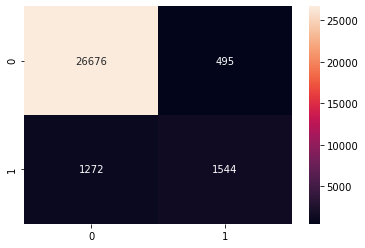

In [38]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### What is our model doing here ?

This model allows to detect fraudulent transactions with a good precision. However, the recall is low because it misclassifies an important amount of fraudulent transactions as non-fraudulent (false negatives).

## 5.5 - Random Forest

In this part, we will perform a Random Forest classification on our data to see if we can further improve the first results. Random forest is an **Ensemble** algorithm which uses the **Bagging** technique.

In [39]:
# Defining a ranges of hyperparameters
max_depth = [4, 6, 8 ,10] # maximum depth of each estimator (tree)
min_samples_split = [2, 5, 10, 20, 30] # minimum samples in a node in order to be split
n_estimators = [30, 40, 50, 80, 100, 150, 200] # number of estimators (trees)

# Defining our GridSearchCV instance
rf_grid = GridSearchCV(estimator=RandomForestClassifier(class_weight="balanced"), cv=5,
                       param_grid={"max_depth":max_depth, 
                                   "min_samples_split":min_samples_split,
                                   "n_estimators":n_estimators},
                       scoring="f1",
                       verbose=2
                      )

# Fitting to training data
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=30; total time=   0.7s
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=30; total time=   0.6s
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=30; total time=   0.6s
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=30; total time=   0.6s
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=30; total time=   0.6s
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=40; total time=   0.8s
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=40; total time=   0.7s
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=40; total time=   0.8s
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=40; total time=   0.8s
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=40; total time=   0.7s
[CV] END ..max_depth=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END ..max_depth=4, min_samples_split=2, n

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_split': [2, 5, 10, 20, 30],
                         'n_estimators': [30, 40, 50, 80, 100, 150, 200]},
             scoring='f1', verbose=2)

In [40]:
# Retrieving best parameters and the best score (f1 score)

print("Hyperparameters that give the best score : {}\n".format(rf_grid.best_params_))
print("Best score : {}\n".format(rf_grid.best_score_))
print("...Done.")

Hyperparameters that give the best score : {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Best score : 0.6995000842884636

...Done.


In [41]:
# Predictions on training set
print("Predictions on training set...")
y_train_pred = rf_grid.predict(X_train)
print("...Done.")

print()

# Predictions on test set
print("Predictions on test set...")
y_test_pred = rf_grid.predict(X_test)
print("...Done.")

Predictions on training set...
...Done.

Predictions on test set...
...Done.


In [42]:
# f1-score on both training and testing sets
print("f1-score on train set : ", rf_grid.score(X_train, y_train))
print("f1-score on test set : ", rf_grid.score(X_test, y_test))

f1-score on train set :  0.6997518610421837
f1-score on test set :  0.6998846597462514


In [43]:
# classifiction report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27171
           1       1.00      0.54      0.70      2816

    accuracy                           0.96     29987
   macro avg       0.98      0.77      0.84     29987
weighted avg       0.96      0.96      0.95     29987



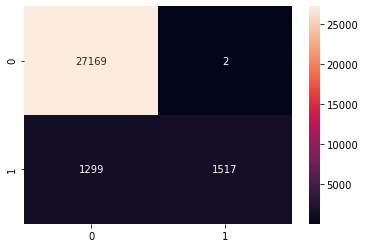

In [44]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### What is our model doing here ?

When we compare the random forest with logistic regression, we notice that we have slightly improved the performances in general. Particularly, we have considerably improved the precision as the number of False Positives (False frauds alerts) has dropped to nearly 0.

## 5.6 - XGBoost

Let's now try another ensemble method: **Boosting**. In this section, we will implement the XGBoost algorithm to see if wee can improve our results.

In [45]:
# Defining a ranges of hyperparameters
max_depth = [3, 4, 6, 8 ,10] # maximum depth of each estimator (tree)
n_estimators = [30, 50, 100] # number of estimators (trees)
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

# Defining our GridSearchCV instance
xgb_grid = GridSearchCV(estimator=XGBClassifier(), cv=5,
                       param_grid={"max_depth":max_depth, 
                                   "learning_rate":learning_rate,
                                   "n_estimators":n_estimators},
                       scoring="f1",
                       verbose=2
                      )

# Fitting to training data
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=30; total time=   0.8s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=30; total time=   0.7s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=30; total time=   0.7s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=30; total time=   0.7s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=30; total time=   0.7s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=   0.9s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=   0.9s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=   0.9s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=   0.9s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=   1.0s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=   1.7s
[CV] END .learning_rate=0.001, max_depth=3, n_e

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [46]:
# Retrieving best parameters and the best score (f1 score)
print("Hyperparameters that give the best score : {}\n".format(xgb_grid.best_params_))
print("Best score : {}\n".format(xgb_grid.best_score_))
print("...Done.")

Hyperparameters that give the best score : {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}

Best score : 0.6997080769095605

...Done.


In [47]:
# Predictions on training set
print("Predictions on training set...")
y_train_pred = xgb_grid.predict(X_train)
print("...Done.")

print()

# Predictions on test set
print("Predictions on test set...")
y_test_pred = xgb_grid.predict(X_test)
print("...Done.")

Predictions on training set...
...Done.

Predictions on test set...
...Done.


In [48]:
# f1-score on both training and testing sets
print("f1-score on train set : ", xgb_grid.score(X_train, y_train))
print("f1-score on test set : ", xgb_grid.score(X_test, y_test))

f1-score on train set :  0.7018211157215307
f1-score on test set :  0.7000461467466543


In [49]:
# classifiction report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27171
           1       1.00      0.54      0.70      2816

    accuracy                           0.96     29987
   macro avg       0.98      0.77      0.84     29987
weighted avg       0.96      0.96      0.95     29987



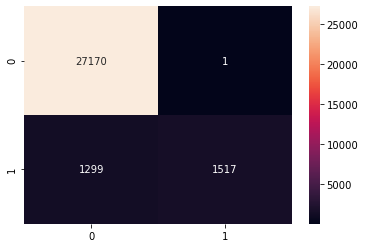

In [50]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### What is our model doing here ?

It looks like this model does not improve our previous results. Therefore, we are achieving a 100% precision but only 54% recall on fraudulent transactions. 

# Conclusion

#### Are the results satisfying ?
Yes, we detect more than 50% of the frauds without making (almost) any false alert (which is way better than detecting no frauds at all). Also, we should not forget that our model has been trained on skewed data (only 9% of transactions were fraudulent). One way to improve the results is to fetch more samples for fraudulent transactions.